In [14]:
import os
import sys
import csv

import numpy as np
import pandas as pd
import scipy.stats as stats

import seaborn as sns
import matplotlib.pyplot as plt

from collections import defaultdict

%matplotlib inline

In [15]:
ukbb_data_file = 'data/04252020_ukb_snp_table_1.csv'

In [16]:
fh = open(ukbb_data_file)
reader = csv.reader(fh)
header = next(reader)

ukbb_data = list()

for row in reader:
    ukbb_data.append(dict(zip(header, row[:2] + list(map(int,row[2:])))))

In [17]:

# construct an rsid->gene mapping
rsid2gene = defaultdict(set)
genes = set()

snp_allele_counts = dict()

for row in ukbb_data:
    rsid2gene[row['rsid']].add(row['gene'])
    snp_allele_counts[row['rsid']] = row
    genes.add(row['gene'])
    

row

{'gene': 'CR1',
 'rsid': 'rs34828104',
 'all_ref/ref_count': 51987,
 'all_ref/alt_count': 160179,
 'all_alt/alt_count': 124027,
 'all_haploid_ref_count': 0,
 'all_haploid_alt_count': 0,
 'tested_ref/ref_count': 131,
 'tested_ref/alt_count': 447,
 'tested_alt/alt_count': 330,
 'tested_haploid_ref_count': 0,
 'tested_haploid_alt_count': 0,
 'pos_ref/ref_count': 59,
 'pos_ref/alt_count': 191,
 'pos_alt/alt_count': 137,
 'pos_haploid_ref_count': 0,
 'pos_haploid_alt_count': 0,
 'neg_ref/ref_count': 76,
 'neg_ref/alt_count': 279,
 'neg_alt/alt_count': 213,
 'neg_haploid_ref_count': 0,
 'neg_haploid_alt_count': 0,
 'pos_severe_ref/ref_count': 53,
 'pos_severe_ref/alt_count': 165,
 'pos_severe_alt/alt_count': 113,
 'pos_severe_haploid_ref_count': 0,
 'pos_severe_haploid_alt_count': 0}

In [18]:
# sorted(genes)

# Compare our gene set to those found for AMD (not how it was built)


In [19]:
fn = 'data/gwas-association-downloaded_2020-04-27-EFO_0001365-withChildTraits.tsv'
fh = open(fn)
reader = csv.reader(fh, delimiter='\t')
header = next(reader)
header

reported_genes = 'REPORTED GENE(S)'
mapped_genes = 'MAPPED_GENE'

amd_gwas_genes = set()

for row in reader:
    row = dict(zip(header, row))
    
    for gene in row[reported_genes].split(','):
        gene = gene.strip()
        amd_gwas_genes.add(gene)
    
    for gene in row[mapped_genes].split(','):
        gene = gene.strip()
        amd_gwas_genes.add(gene)
len(amd_gwas_genes)

317

In [20]:
len(amd_gwas_genes & genes), len(genes)

(9, 67)

In [21]:
# study = 'pos_severe'
# study = 'pos'
study = 'neg'

plink_results_file = 'data/%s.PHENO1.glm.logistic.adjusted' % study
plink_details_file = 'data/%s.PHENO1.glm.logistic' % study

In [22]:
fh = open(plink_details_file)
reader = csv.reader(fh, delimiter='\t')
header = next(reader)

plink_details = dict()
for row in reader:
    row = dict(zip(header, row))
    if row['TEST'] == 'ADD':
        plink_details[row['ID']] = row

len(plink_details), list(plink_details.items())[0]

(2097,
 ('rs61775589',
  {'#CHROM': '1',
   'POS': '11028301',
   'ID': 'rs61775589',
   'REF': 'C',
   'ALT': 'T',
   'A1': 'C',
   'TEST': 'ADD',
   'OBS_CT': '337147',
   'OR': '0.956961',
   'LOG(OR)_SE': '0.122567',
   'Z_STAT': '-0.35893',
   'P': '0.719648'}))

In [23]:
fh = open(plink_results_file)
reader = csv.reader(fh, delimiter='\t')

header = next(reader)
print(header)

plink_results = list()

for row in reader:
    chrom = row[0]
    rsid = row[1]
    allele = row[2]
    unadjusted = float(row[3])
    fdrbh = float(row[9])
    
    plink_results.append([chrom, rsid, allele, unadjusted, fdrbh])

len(plink_results)

['#CHROM', 'ID', 'A1', 'UNADJ', 'GC', 'BONF', 'HOLM', 'SIDAK_SS', 'SIDAK_SD', 'FDR_BH', 'FDR_BY']


2097

## Pull out and build a table from the study-wide significant hits

In [24]:
gt_types = ["%s_ref/ref_count", "%s_ref/alt_count", "%s_alt/alt_count"]

genotype_counts_keys = [t % 'all' for t in gt_types] + [t % study for t in gt_types]

ofh = open('results/table3_ukbb_results_%s.csv' % study, 'w')
writer = csv.writer(ofh)

sig_chroms = set()

results_header = ["rsid", "chrom", "pos", "ref", "alt", "OR", "log(OR)se", "z_stat", "allele", "unadjusted", "FDR_BH", "genes"] + genotype_counts_keys 
writer.writerow(results_header)
least_sig_sig = None

marginally_significant_table = list()

for chrom, rsid, allele, unadjusted, fdrbh in plink_results:
    details = plink_details[rsid]
    genotype_counts = [snp_allele_counts[rsid][k] for k in genotype_counts_keys]
        
    if fdrbh < 0.05:
        if least_sig_sig is None or unadjusted > least_sig_sig:
            least_sig_sig = unadjusted
        
        writer.writerow([rsid, chrom, details['POS'], details['REF'], details['ALT'], details['OR'], details['LOG(OR)_SE'], details['Z_STAT'], allele, unadjusted, fdrbh, ','.join(rsid2gene[rsid])] + genotype_counts)
        print(rsid, chrom, details['POS'], details['REF'], details['ALT'], details['OR'], details['LOG(OR)_SE'], details['Z_STAT'], allele, unadjusted, fdrbh, ','.join(rsid2gene[rsid]))
        sig_chroms.add(int(chrom))
    
    if unadjusted < 1e-2:
        marginally_significant_table.append(
            [rsid, chrom, details['POS'], details['REF'], details['ALT'], details['OR'], details['LOG(OR)_SE'], details['Z_STAT'], allele, unadjusted, fdrbh, ','.join(rsid2gene[rsid])] + genotype_counts            
        )
        

ofh.close()

ofh = open('results/table4_ukbb_results_marginally_sig_%s.csv' % study, 'w')
writer = csv.writer(ofh)
writer.writerow(results_header)
writer.writerows(marginally_significant_table)
ofh.close()

least_sig_sig

rs2227568 10 75673879 T C 1.3293 0.075501 3.77014 T 0.000163155 0.0068525 PLAU


0.000163155

SpearmanrResult(correlation=0.7534089722869851, pvalue=5.7320802469532384e-06)

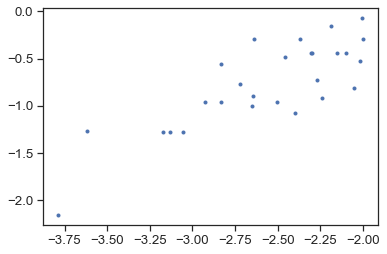

In [25]:
split = list(zip(*marginally_significant_table))
u = np.log10(split[9])
a = np.log10(split[10])
plt.plot(u, a, '.')

stats.spearmanr(u, a)

## Build a mini-Manhattan plot

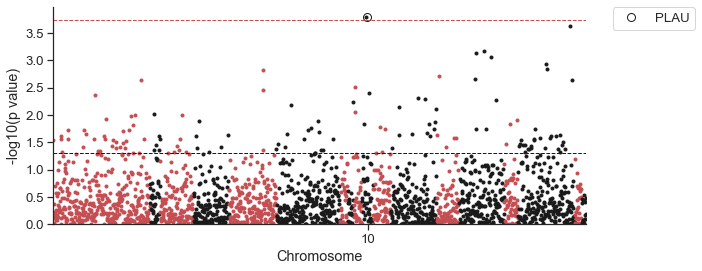

In [26]:
sns.set(style='ticks', font_scale=1.2)
plt.figure(figsize=(10,4))

neglog10 = lambda p: -1*np.log10(p)

chromosomes = sorted(set(map(int,list(zip(*plink_results))[0])))

start_pos = 0
alternate = 0
tick_positions = list()
tick_labels = list()

gene_markers = list()
sig_genes = set()

for this_chrom in chromosomes:
    
    unadjusted_pvalues = list()
    
    for chrom, rsid, allele, unadjusted, fdrbh in sorted(plink_results):
        if int(chrom) != this_chrom:
            continue
        
        unadjusted_pvalues.append(neglog10(unadjusted))
        
        if fdrbh < 0.05:
            for gene in rsid2gene[rsid]:
                gene_markers.append((gene, len(unadjusted_pvalues)+start_pos, unadjusted, alternate))
                sig_genes.add(gene)
    
    fmt = 'k.'
    if alternate % 2 == 0:
        fmt = 'r.'
    
    plt.plot(range(start_pos, start_pos+len(unadjusted_pvalues)) ,unadjusted_pvalues, fmt)

    if this_chrom in sig_chroms:
        tick_positions.append(len(unadjusted_pvalues)/2+start_pos)
        tick_labels.append(this_chrom)
    
    start_pos += len(unadjusted_pvalues)
    alternate += 1
    
# plot the significant genes
markerstyles = ['o', 's', 'v', '*', 'P', 'D', 'x', 'h', '|']
legend_names = list()
for i, gene in enumerate(sig_genes):
    _, xpos, unadj, alternate = zip(*[(g,x,p,a) for g,x,p,a in gene_markers if g == gene])
    
    color = 'k'
    if alternate[0] % 2 == 0:
        color = 'r'
#     xpos += np.random.normal(0, 20, 1)
    plt.plot(xpos, list(map(neglog10,unadj)), lw=0, color='none', markeredgecolor=color, markersize=8, marker=markerstyles[i], label=gene)
    legend_names.append(gene)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)

# Add some markers for where the significance threshold is
# and customize the tick marks and labels
un_alpha = neglog10(0.05)
# bh_alpha = neglog10(0.0007)
bh_alpha = neglog10(1.1*least_sig_sig)

plt.plot([0, len(plink_results)], [un_alpha, un_alpha], 'k--', lw=1)
plt.plot([0, len(plink_results)], [bh_alpha, bh_alpha], 'r--', lw=1)
plt.xlim(0,len(plink_results))
plt.ylim(0)
plt.ylabel('-log10(p value)')

plt.xticks(tick_positions, tick_labels)
plt.xlabel('Chromosome')

sns.despine()
plt.tight_layout()

plt.savefig('figures/ukbb_complwas_%s.pdf' % study)